In [37]:
from tqdm import tqdm
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from PIL import Image
from os.path import join
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import torchvision.transforms as transforms
import cv2
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torchvision.models.vgg import vgg16
torch.autograd.set_detect_anomaly(True)

In [10]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def HRtransform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def LRtransform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

In [46]:
class SRFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(SRFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.HRtransform = HRtransform(crop_size)
        self.LRtransform = LRtransform(crop_size, upscale_factor)

    def __getitem__(self, index):
        HRimage = self.HRtransform(Image.open(self.image_filenames[index]))
        LRimage = self.LRtransform(HRimage)
        return LRimage, HRimage

    def __len__(self):
        return len(self.image_filenames)

In [47]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88
trainDataSet = SRFolder('/kaggle/input/div2k/DIV2K_train_HR/DIV2K_train_HR', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
trainDataLoader = DataLoader(dataset=trainDataSet, num_workers=4, batch_size=64, shuffle=True)

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

In [26]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [77]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        super(Generator, self).__init__()
        self.num_upsample_blocks = int(math.log(scale_factor, 2))
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        blocks = []
        for _ in range(5):
            blocks.append(ResidualBlock(64))
        self.blocks = nn.Sequential(*blocks)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(self.num_upsample_blocks)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block6 = self.blocks(block1)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2

In [79]:
class Discriminator(nn.Module):
    def __init__(self, features = (64,128, 128, 256, 256, 512, 512)):
        super(Discriminator, self).__init__()
        self.features = features
        net = []
        net.append(nn.Conv2d(3, 64, kernel_size=3, padding=1))
        net.append(nn.LeakyReLU(0.2))
        
        in_channel = features[0]
        for _, feature in enumerate(features):
            net.append(nn.Conv2d(in_channel, feature, kernel_size = 3, stride = 2, padding = 1))
            net.append(nn.BatchNorm2d(feature))
            net.append(nn.LeakyReLU(0.2))
            in_channel = feature
        
        net.append(nn.AdaptiveAvgPool2d(1))
        net.append(nn.Conv2d(512, 1024, kernel_size=1))
        net.append(nn.LeakyReLU(0.2))
        net.append(nn.Conv2d(1024, 1, kernel_size=1))
        self.net = nn.Sequential(*net)
    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [80]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        adversarial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

In [81]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [84]:
generator = Generator(UPSCALE_FACTOR)
discriminator = Discriminator()
generator_criterion = GeneratorLoss()

In [85]:
generator_criterion = generator_criterion.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)


In [86]:
optimizerG = optim.Adam(generator.parameters(), lr=0.0002)
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002)

In [87]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [89]:
import csv
import os

N_EPOCHS = 150
epoch_results = {'epoch': [], 'd_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}

for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(trainDataLoader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    generator.train()
    discriminator.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()

        fake_img = generator(z)

        # Train Discriminator
        discriminator.zero_grad()
        real_out = discriminator(real_img).mean()
        fake_out = discriminator(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        # Train Generator
        fake_img = generator(z)
        fake_out = discriminator(fake_img).mean()
        generator.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        # Loss for current batch before optimization
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    # Calculate average loss and score for the epoch
    epoch_d_loss = running_results['d_loss'] / running_results['batch_sizes']
    epoch_g_loss = running_results['g_loss'] / running_results['batch_sizes']
    epoch_d_score = running_results['d_score'] / running_results['batch_sizes']
    epoch_g_score = running_results['g_score'] / running_results['batch_sizes']

    # Store epoch results
    epoch_results['epoch'].append(epoch)
    epoch_results['d_loss'].append(epoch_d_loss)
    epoch_results['g_loss'].append(epoch_g_loss)
    epoch_results['d_score'].append(epoch_d_score)
    epoch_results['g_score'].append(epoch_g_score)

    # Save results at the end of each epoch if needed
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

# After training, save all epoch results to a CSV file
csv_file = os.path.join(out_path, 'training_metrics.csv')
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'D_Loss', 'G_Loss', 'D_Score', 'G_Score'])
    for i in range(N_EPOCHS):
        writer.writerow([epoch_results['epoch'][i], epoch_results['d_loss'][i],
                         epoch_results['g_loss'][i], epoch_results['d_score'][i],
                         epoch_results['g_score'][i]])


[1/150] Loss_D: 0.7814 Loss_G: 0.0439 D(x): 0.5927 D(G(z)): 0.3092: 100%|██████████| 13/13 [00:32<00:00,  2.53s/it]
[2/150] Loss_D: 0.3709 Loss_G: 0.0210 D(x): 0.7973 D(G(z)): 0.1393: 100%|██████████| 13/13 [00:32<00:00,  2.51s/it]
[3/150] Loss_D: 0.0874 Loss_G: 0.0169 D(x): 0.9550 D(G(z)): 0.0338: 100%|██████████| 13/13 [00:32<00:00,  2.47s/it]
[4/150] Loss_D: 0.0247 Loss_G: 0.0151 D(x): 0.9874 D(G(z)): 0.0094: 100%|██████████| 13/13 [00:32<00:00,  2.49s/it]
[5/150] Loss_D: 0.0114 Loss_G: 0.0140 D(x): 0.9938 D(G(z)): 0.0044: 100%|██████████| 13/13 [00:32<00:00,  2.48s/it]
[6/150] Loss_D: 0.0069 Loss_G: 0.0121 D(x): 0.9966 D(G(z)): 0.0026: 100%|██████████| 13/13 [00:31<00:00,  2.44s/it]
[7/150] Loss_D: 0.1284 Loss_G: 0.0121 D(x): 0.9169 D(G(z)): 0.0405: 100%|██████████| 13/13 [00:32<00:00,  2.48s/it]
[8/150] Loss_D: 0.1068 Loss_G: 0.0120 D(x): 0.9542 D(G(z)): 0.0414: 100%|██████████| 13/13 [00:32<00:00,  2.48s/it]
[9/150] Loss_D: 0.0193 Loss_G: 0.0115 D(x): 0.9940 D(G(z)): 0.0078: 100%

In [90]:
# torch.save(generator.state_dict(), "super_res_gen.pth")

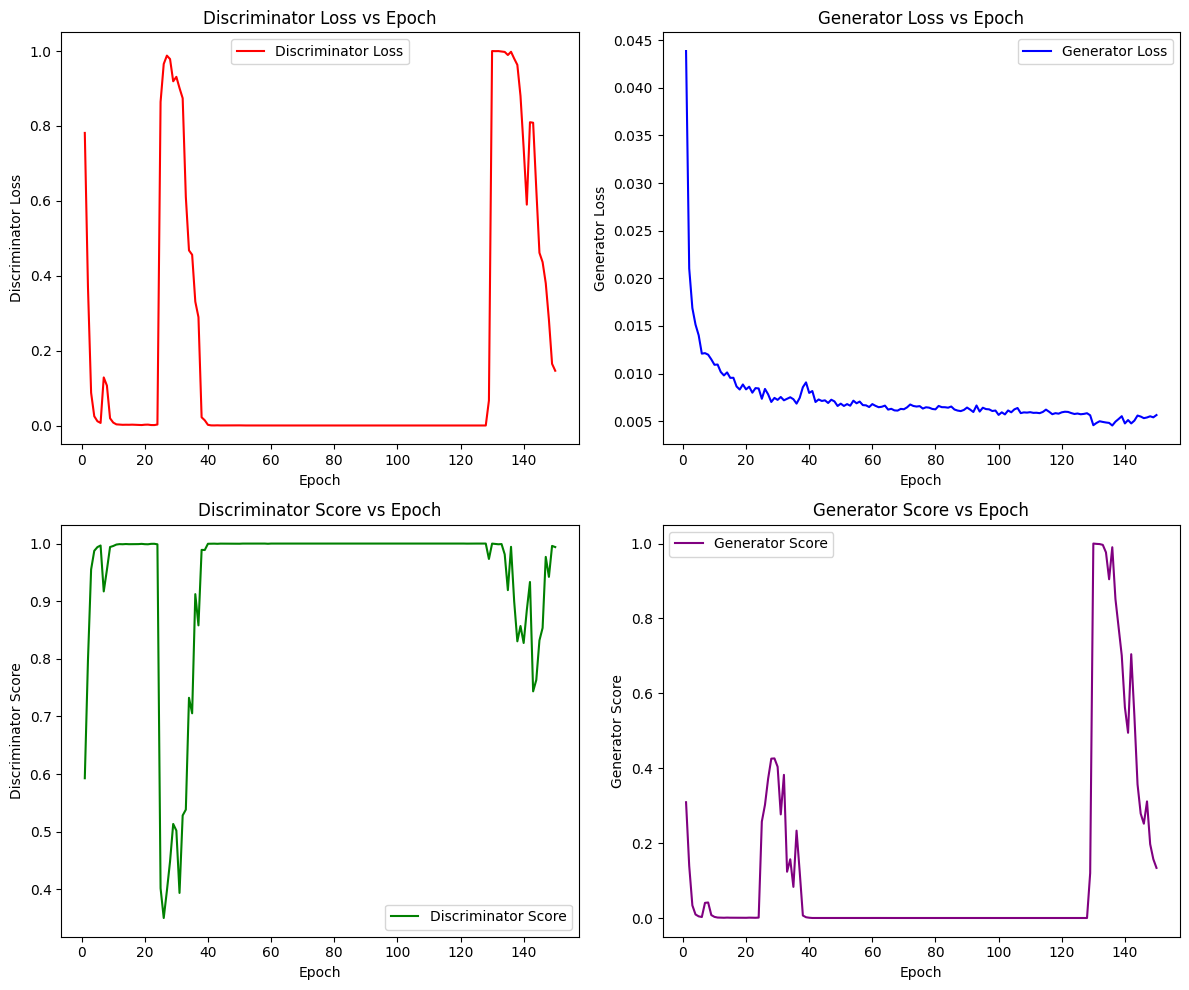

In [129]:
import matplotlib.pyplot as plt

# Assuming 'epoch_results' is already populated with the data during training

epochs = epoch_results['epoch']
d_loss = epoch_results['d_loss']
g_loss = epoch_results['g_loss']
d_score = epoch_results['d_score']
g_score = epoch_results['g_score']

# Create subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Discriminator Loss
axs[0, 0].plot(epochs, d_loss, label='Discriminator Loss', color='red')
axs[0, 0].set_title('Discriminator Loss vs Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Discriminator Loss')
axs[0, 0].legend()

# Plot Generator Loss
axs[0, 1].plot(epochs, g_loss, label='Generator Loss', color='blue')
axs[0, 1].set_title('Generator Loss vs Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Generator Loss')
axs[0, 1].legend()

# Plot Discriminator Score
axs[1, 0].plot(epochs, d_score, label='Discriminator Score', color='green')
axs[1, 0].set_title('Discriminator Score vs Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Discriminator Score')
axs[1, 0].legend()

# Plot Generator Score
axs[1, 1].plot(epochs, g_score, label='Generator Score', color='purple')
axs[1, 1].set_title('Generator Score vs Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Generator Score')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [119]:
import torch
model = torch.load("super_res_gen.pth", weights_only=True)
generator2 = Generator(UPSCALE_FACTOR)
generator2.load_state_dict(model)

<All keys matched successfully>

In [104]:
testDataSet = SRFolder('/kaggle/input/div2k/DIV2K_valid_HR/DIV2K_valid_HR', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
testDataLoader = DataLoader(dataset=testDataSet, num_workers=4, batch_size=64, shuffle=True)

In [155]:
import torch
import math

def calculate_psnr_value(output, target, max_value=1.0):
    # Calculate Mean Squared Error (MSE) between the output and target
    mse = torch.mean((output - target) ** 2)
    
    # Avoid division by zero in case of perfect matches
    if mse == 0:
        return float('inf')  # Return infinity for perfect match
    
    # PSNR formula
    psnr = 20 * math.log10(max_value / math.sqrt(mse))
    return psnr


In [156]:
def calculate_psnr(generator, test_loader, device='cuda'):
    # Move model to the same device as input (GPU)
    generator.to(device)
    
    generator.eval()  # Set the model to evaluation mode
    psnr_list = []

    with torch.no_grad():
        for data in test_loader:
            # Assuming 'data' contains input and ground truth in a tuple
            low_res_images, high_res_images = data
            low_res_images = low_res_images.to(device)  # Move input to GPU
            high_res_images = high_res_images.to(device)  # Move target to GPU
            
            # Generate the output
            generated_images = generator(low_res_images)
            
            # Post-process the generated and target images
            generated_images = torch.clamp(generated_images, 0.0, 1.0)
            high_res_images = torch.clamp(high_res_images, 0.0, 1.0)

            # Calculate PSNR (Peak Signal-to-Noise Ratio) between generated and target
            psnr = calculate_psnr_value(generated_images, high_res_images)
            psnr_list.append(psnr)
    
    avg_psnr = sum(psnr_list) / len(psnr_list)
    print(f"Average PSNR: {avg_psnr} dB")
    return avg_psnr

# Call the function with the model and dataloader
calculate_psnr(generator2, testDataLoader)


Average PSNR: 24.721583433205502 dB


24.721583433205502

In [157]:
calculate_psnr(generator2, trainDataLoader)

Average PSNR: 24.83443752830062 dB


24.83443752830062

In [158]:
calculate_psnr(generator2, testDataLoader)

Average PSNR: 24.49498647859282 dB


24.49498647859282

In [126]:
class SRDataset(Dataset):
    def __init__(self, root_dir, lowres_transform, highres_transform, both_transform):
        super(SRDataset, self).__init__()
        self.root_dir = root_dir
        
        self.lowres_transform = lowres_transform
        self.highres_transform = highres_transform
        self.both_transform = both_transform
        self.list_of_files = os.listdir(os.path.join(root_dir))
        
    def __len__(self):
        return len(self.list_of_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.root_dir, self.list_of_files[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.both_transform(image = image)['image']
        
        
        low_res_image = self.lowres_transform(image=image)['image']
        high_res_image = self.highres_transform(image=image)['image']
        
        return low_res_image, high_res_image

In [127]:
high_res = 128
low_res = high_res//4
num_channels = 3

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True


highres_transform = A.Compose(
    [
        A.Resize(width = high_res, height = high_res),
        A.Normalize(mean = [0,0,0], std = [1,1,1]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Resize(width = low_res, height = low_res, interpolation = Image.BICUBIC),
        A.Normalize(mean = [0,0,0], std = [1,1,1]),
        ToTensorV2(),
    ]
)

both_transform = A.Compose(
    [
        A.RandomCrop(width = high_res, height = high_res),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

In [128]:
num_workers = 4
val_dataset = SRDataset(
    root_dir = r'/kaggle/input/div2k/DIV2K_valid_HR/DIV2K_valid_HR',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    both_transform = both_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

 19%|█▉        | 19/100 [00:02<00:08,  9.12it/s]


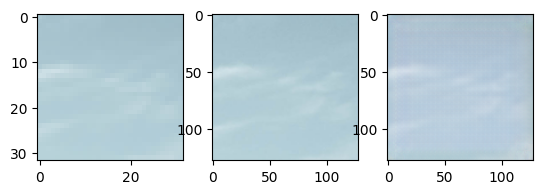

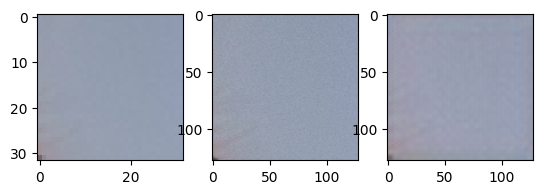

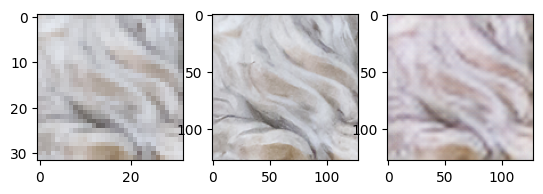

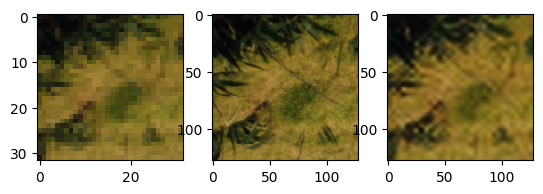

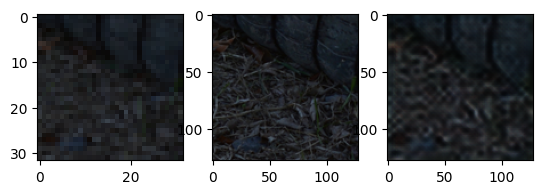

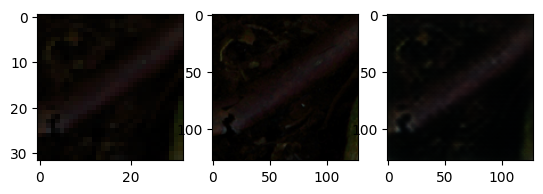

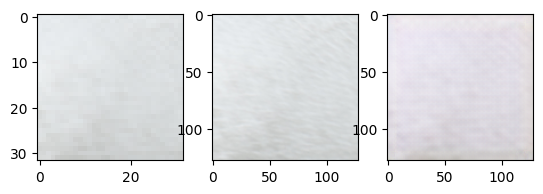

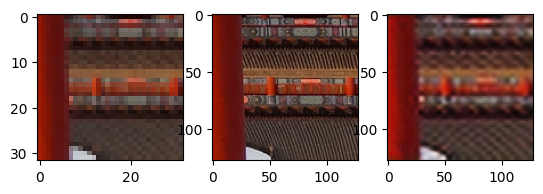

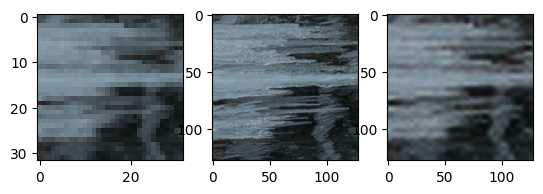

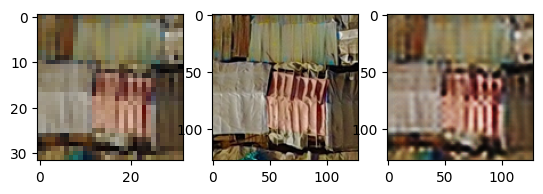

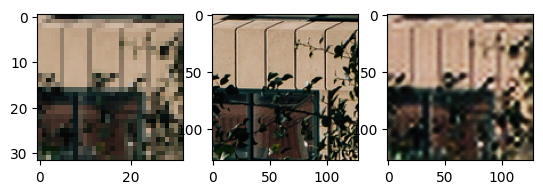

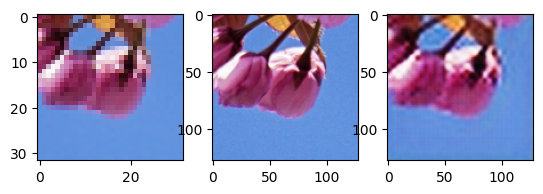

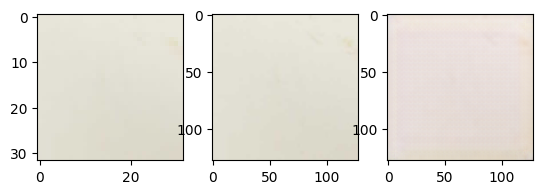

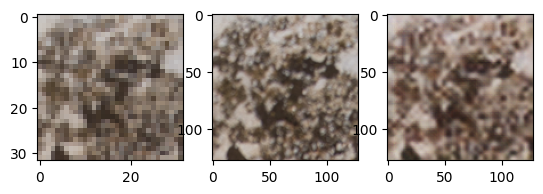

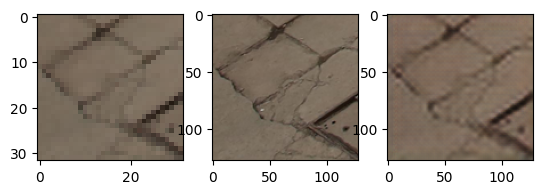

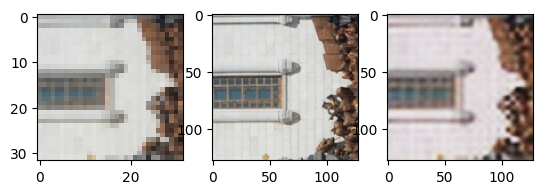

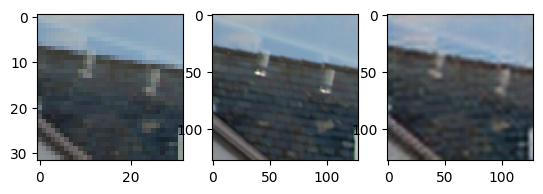

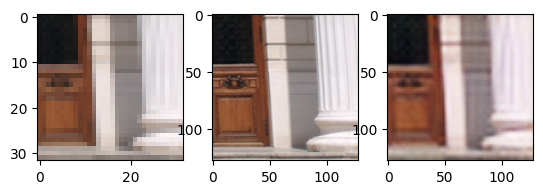

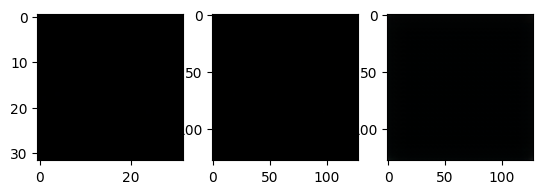

In [166]:
import matplotlib.pyplot as plt

topil = transforms.ToPILImage()
i = 0
for iteration, (low_res, high_res) in enumerate(tqdm(val_loader)):
    i += 1
    if(i>=20):
        break
    fig, axes = plt.subplots(1, 3)
    
    axes[0].imshow(low_res[0].permute(1,2,0))
    axes[1].imshow(high_res[0].permute(1, 2, 0))
    low_res = low_res.to(device)
    generator2.eval()
    with torch.no_grad():
        generated_image = generator2(low_res)
    fake_high_res = generated_image.to('cpu').detach()
    axes[2].imshow(fake_high_res[0].permute(1, 2, 0))